In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from econml.ortho_forest import ContinuousTreatmentOrthoForest as CausalForest
from tqdm.auto import tqdm
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [3]:
welfare = pd.read_csv("welfarelabel.csv", low_memory=False)
welfare

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,preteen_miss,teens_miss,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss
0,1986,1,working fulltime,40.000000,38.613701,1.1395408,270.00000,44.000000,someone else,private,...,0,0,0,0,0,0,0,0,0,0
1,1986,2,keeping house,41.733318,38.613701,1,195.00000,51.000000,someone else,private,...,0,0,0,1,0,0,1,0,0,0
2,1986,3,working fulltime,40.000000,38.613701,1.1395408,184.00000,51.000000,someone else,private,...,0,0,0,1,0,0,0,0,0,0
3,1986,4,retired,41.733318,38.613701,1,311.00000,36.000000,someone else,1,...,0,0,0,0,0,0,1,0,0,0
4,1986,5,working parttime,41.733318,38.613701,1.1395408,449.41599,40.335918,someone else,1.8203658,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,2010,2040,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,...,0,0,0,0,0,0,1,1,0,0
36497,2010,2041,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,...,0,0,0,0,0,0,1,1,0,0
36498,2010,2042,working fulltime,40.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,...,0,0,0,1,0,0,0,1,0,0
36499,2010,2043,working fulltime,49.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,...,0,0,0,1,0,0,1,1,0,0


Just a reference point to see how many actual covariates are in the Welfare dataset

In [4]:
def dropDummy(cols):
    filtered = []
    for col in cols:
        if "_" not in col:
            filtered.append(col)
    return filtered

realCols = dropDummy(list(welfare.columns))
print("Number of covariates for the welfare data set is", len(realCols) - 1) # Approximate number of covariates, we drop one column because of the label column

Number of covariates for the welfare data set is 61


Generating data (per page 17 of BART and BCF paper)

In [183]:
"""
Execute heterogeneous treatment on data

Returns: X, X@betas
"""
def heterogeneousTreatment(X, treatments, betas, effect):
    xb = X@betas
#     for i in range(X.shape[0]):
#         if int(treatments[i]) > 0:
#             xb[i] += 1 + effect * X[i][1] * X[i][4]
    treated = treatments>0
    
    # heterogeneous treatment is 1 + effect*x_2*x_5
    xb[treated] += 1 + 3*X[treated.ravel(), 1]*X[treated.ravel(), 4]

    X = np.append(X, treatments, axis=1)
    return X, xb


In [186]:
"""
Data Generating Process
    Configure treatment effect heterogeneity, independent of regression form and sample size

Params:
    effect_type - heterogeneous vs homogeneous
    effect_homogeneous - if effect_type is homogeneous, controls what the treatment coefficient is
    effect_heterogeneous - if effect_type is heterogeneous, controls n where the treatment coefficient is 1 + n * x_2 * x_5
    treatment_probability - probability that an observation is assigned the treatment, default is 0.5
    order - order of interactions between covariates desired, as order is increased, number of covariates and nonlinearity (if specified) is also increased
    linear - flag to control whether the dgp has exponents larger than 1 
    cc - number of continuous covariates to be included (pre-introduction of n order interactions)
    N - sample size
    rho - variance between continuous covariates
Returns: y, X, betas, features
"""
def dgp(effect_type="heterogeneous", effect_homogeneous=3, effect_heterogeneous=2,
        treatment_probability=0.5, order=3, linear=False, cc=4, N=1000, rho=0.2):
    
    error = np.random.normal(size=(N,1))
    
    added_covariates = 2
    if linear: 
        # linear => include 2 more continuous covariates
        # to have approximately same number of covariates between the linear and nonlinear cases
        cov = (np.eye(cc+added_covariates) * (1-rho)) + (np.ones((cc+added_covariates, cc+added_covariates)) * rho)

        # generate N continuous covariates of X
        X = np.random.multivariate_normal(np.zeros(cc+added_covariates), 
            cov, size=N, check_valid='warn', tol=1e-8) 
    else:
        cov = (np.eye(cc) * (1-rho)) + (np.ones((cc, cc)) * rho)

        # generate N continuous covariates of X
        X = np.random.multivariate_normal(np.zeros(cc), 
            cov, size=N, check_valid='warn', tol=1e-8)

    # add binary [0, 1] covariate
    X = np.append(X, np.random.randint(2, size=N).reshape((-1, 1)), axis=1) # add binary [0, 1] covariate

    cat_elements = [1, 2, 3]
    cat_probabilities = [0.2, 0.5, 0.3] # arbitrary

    # add unordered categorical [1, 2, 3] covariate
    X = np.append(X, np.random.choice(cat_elements, size=N, p=cat_probabilities).reshape((-1, 1)), axis=1)

    # add N order interactions if linear is false for X covariates
    # increases number of covariates (to have a high dimensional dataset)
    poly = PolynomialFeatures(order, interaction_only=linear) 
    X = poly.fit_transform(X)
    X = X[:,1:] # drop the constant term
    features = (poly.get_feature_names()[1:])
    features.append("w")

    treat_elements = [0, 1]
    treat_probabilities = [1 - treatment_probability, treatment_probability]

    # randomly assigned treatments with propensity treatment_probability
    treatments = np.random.choice(treat_elements, size=N, p=treat_probabilities).reshape((-1, 1))
    
    # heterogeneous vs. homogeneous treatments
    if effect_type == "homogeneous":
        betas = np.append(np.random.normal(size=X.shape[1]), [effect_homogeneous]).reshape(-1,1)
        X = np.append(X, treatments, axis=1)
        xb = X@betas
    else:
        betas = np.random.normal(size=X.shape[1]).reshape(-1,1)
        X, xb = heterogeneousTreatment(X, treatments, betas, effect_heterogeneous)

    y = xb + error 
    return y, X, betas, features, treatments


> "We find that including an estimate of the
propensity score as a covariate reduces the bias of regularized treatment effect estimates
in finite samples. We recommend including an estimated propensity score as a covariate
as routine practice regardless of the particular models or algorithms used to estimate
treatment effects since regularization is necessary to estimate heterogeneous treatment
effects non- or semiparamaterically or in high dimensions. To illustrate the potential for
biased estimation and motivate our fix, we introduce two key concepts: Regularization
induced confounding and targeted selection."

page 7, (Hahn, Murray, and Carlvaho)

=> Our homogeneous treatment selection is purely random and therefore we have no targeted selection into treatment.

$Y = \alpha Z + X \beta + \epsilon $ where $Z$ is the indicator of treatment, $\alpha$ ATE

We assume:
- observational/experimental (which one?) data
- conditional unfoundedness/ignorability
- covariate-dependent treatment effects => individuals can have different responses to treatment according to their covariates
- binary treatments (not continuous)

we write $ E(Y_i | x_i, z_i) = f(x_i, z_i) $

we want $\tau(x_i) := f(x_i, 1) - f(x_i, 0) = ATT - ATC$

In all cases the estimands of interest are either conditional average treatment effects for individual i accounting for all the variables, estimated by the posterior mean
treatment effect $\tau(x_i)$, or sample subgroup average treatment effects estimated by
$\Sigma_{i\in S} \tau(x_i)$, where S is the subgroup of interest. Credible intervals are computed from
MCMC output.

> [hetAI16] develop the idea of “causal trees.” The purpose and method are qualitatively similar to the grouped average treatment effects. The main difference is that the groups in [hetAI16] are determined by a low-depth regression tree instead of by quantiles of a noisy estimate of the conditional average treatment effect. As above, sample-splitting is used to facilitate inference.
> Causal trees share many downsides of regression trees. In particular, the branches of the tree and subsequent results can be sensitive to small changes in the data. [hetWA18] develop a causal forest estimator to address this concern. This causal forest estimates E[yi(1)−yi(0)|Xi=x] directly. Unlike most machine learning estimators, [hetWA18] prove that causal forests are consistent and pointwise asymptotically normal, albeit with a slower than n‾√ rate of convergence. In practice, this means that either the sample size must be very large (and/or x relatively low dimension) to get precise estimates.

url: https://datascience.quantecon.org/applications/heterogeneity.html#het-wager2018

### Running Causal Forest

Below I am trying to fit the CausalForest Model to our DGP. 

Turns out that there are multiple options for CausalForest models in econml and that they behave differently. I am still figuring out why the DML one does not estimate correctly, even under homogeneous treatment.

The grf (Generalized Random Forest) submodule CausalForest does estimate the treatment effect correctly, but the functions that do so (predict(X_test)) are contrary to expectations. It also estimates 1.5 for heterogeneous effect (GT is 2), so it's biased.

In terms of what the matrices should include, here is an example from online
   - W = ccdefault_causal_df[['_spend','_tpm','_ppm','_RETAIL','_URBAN','_RURAL','_PREMIUM']]
   - X = ccdefault_causal_df[['_CC_LIMIT']]
   - T = ccdefault_causal_df[['_TREATMENT']]
   - Y = ccdefault_causal_df[['_LTV']]
    
- W matrix contains all the covariates that we suspect might affect treatment effect heterogeneity (this means model specification! => first bad sign).
- X contains all the covariates we use for Y
- Y is outcomes of interest
- T is the treatment indicator vector/column

documentation model below: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html#econml.grf.CausalForest

In [324]:
from econml.grf import CausalForest
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference

def estimate_grf(y, X, treatments, test_size=0.2, criterion='mse'):
    # split data into train and test sets 
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=test_size)
        
    # specify hyperparams of model
    est = CausalForest(criterion='mse', n_estimators=1000,       
                          min_samples_leaf=1, 
                          max_depth=100, max_samples=0.5,
                          honest=True, inference=True)

    # fit model
    est.fit(X_train, T_train, Y_train)
    
    predict, sigma = est.predict_and_var(X_test)
    
    return est, predict, sigma

url: https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML

In [345]:
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference

def estimate_dml(y, X, treatments, test_size=0.2, criterion='mse'):
    # split data into train and test sets 
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=test_size)

    # homo => no covariates affecting treatment
    if effect_type == "homogeneous":
        
        # not sure what's best here? Probably leave empty
#         W_train = X_train[:, :-1]
#         W_test = X_test[:, :-1]
        W_train = None
        W_test = None
    else:
        # W represents the covariates affecting treatment
        W_train = X_train[:, [1, 4]] # effect_modifiers
        W_test = X_test[:, [1, 4]]
        
    # specify hyperparams of model
    est = CausalForestDML(criterion='mse', n_estimators=1000,       
                          min_samples_leaf=1, 
                          max_depth=100, max_samples=0.5,
                          discrete_treatment=True, 
                          honest=True, inference=True)

    # fit model
    est.fit(Y_train.ravel(), T_train, X=X_train, W=W_train)
    
     # Estimate the treatment effects on test set
#     treatment_effects = est.effect(X_test)
    treatment_effects = None

    # Confidence intervals via Bootstrap-of-Little-Bags for forests
    lb, ub = est.effect_interval(X_test, alpha=0.05)

    # Estimate the CATE with the test set (is just mean treatment_effect)
    cate_test = est.const_marginal_ate(X_test)
    
    return est, treatment_effects, lb, ub, cate_test

In [346]:
S = 100 # num simulations
hetero_res_cate = np.zeros(shape=(S)) # save results

# run for 100 simulations
for i in tqdm(range(S)):
    # generate data from DGP
    effect_type = "heterogeneous"
    y, X, trueBetas, featureNames, treatments = dgp(effect_type=effect_type, 
                                                order=3, treatment_probability=0.5, linear=True)
    
    est, treatment_effects, lb, ub, cate_test = estimate_dml(y, X, treatments) # dml
#     est, treatment_effects, predict, sigma = estimate_grf(y, X, treatments)
    
#   hetero_res_cate[i] = predict.mean() # std
    hetero_res_cate[i] = cate_test # dml

In [340]:
S = 100 # num simulations
homo_res_cate = np.zeros(shape=(S)) # save results

# run for 100 simulations
for i in tqdm(range(S)):
    # generate data from DGP
    effect_type = "homogeneous"
    y, X, trueBetas, featureNames, treatments = dgp(effect_type=effect_type, 
                                                order=3, treatment_probability=0.5, linear=True)
    
    est, treatment_effects, lb, ub, cate_test = estimate_dml(y, X, treatments) # dml
#     est, treatment_effects, predict, sigma = estimate_grf(y, X, treatments)
    
#     homo_res_cate[i] = predict.mean() # std
    homo_res_cate[i] = cate_test # dml

In [342]:
homo_res_cate.mean()

Below is a single simulation using DGP + either CausalForest or CausalForestDML()

In [386]:
# generate data from DGP
effect_type = "heterogeneous"
y, X, trueBetas, featureNames, treatments = dgp(N=1000, effect_type=effect_type, 
                                                order=3, treatment_probability=0.5, linear=True)

# split data into train and test sets 
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=0.2)

# homo => no covariates affecting treatment
if effect_type == "homogeneous":
    W_train = X_train
    W_test = X_test
else:
    W_train = X_train[:, [1, 4]] # effect_modifiers
    W_test = X_test[:, [1, 4]]

W_train, W_test = None, None

In [387]:
# specify hyperparams of model
est = CausalForest(criterion='mse', n_estimators=1000,       
                      min_samples_leaf=1, 
                      max_depth=100, max_samples=0.5, 
                      honest=True, inference='blb')


# fit model
est.fit(X_train, T_train, Y_train)

CausalForest(inference='blb', max_depth=100, max_samples=0.5,
             min_samples_leaf=1, n_estimators=1000)

In [388]:
preds, var = est.predict_and_var(X_test)
preds.mean()

In [394]:
est.predict_tree_average(X_test).shape # idk what this is vs predict()

AttributeError: 'CausalForestDML' object has no attribute 'predict_tree_average'

In [390]:
# DML
est = CausalForestDML(criterion='het', n_estimators=1000,       
                      min_samples_leaf=1, 
                      max_depth=100, max_samples=0.5,
                      discrete_treatment=True, 
                      honest=True, inference=True)
est.fit(Y_train.ravel(), T=T_train, X=X_train, W=W_train)

In [391]:
# this only works for CausalForestDML 

# Estimate the treatment effects on test set
treatment_effects = est.effect(X_test)

# Confidence intervals via Bootstrap-of-Little-Bags for forests
lb, ub = est.effect_interval(X_test, alpha=0.05)

# Estimate the CATE with the test set
est.const_marginal_ate(X_test)

array([47.08998115])

In [392]:
est.const_marginal_ate_inference(X_test)

In [393]:
est.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,33.75,4.562,7.398,0.0,26.246,41.254
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,31.867,6.588,4.837,0.0,21.031,42.703
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,35.339,6.312,5.599,0.0,24.957,45.721


In [282]:
est.cate_treatment_names()

['T0_1']

 98%|===================| 655/670 [00:13<00:00]        

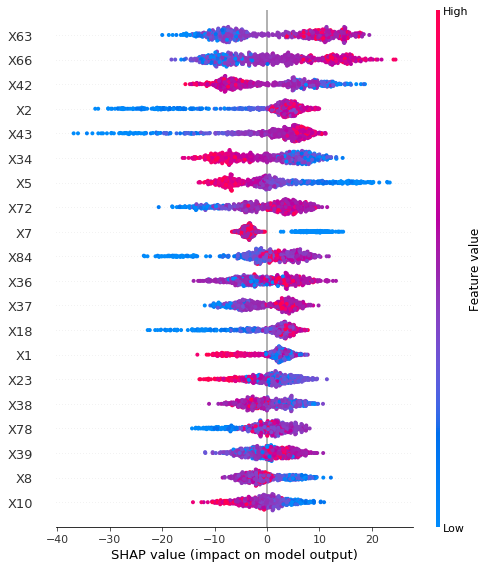

In [231]:
# Shapley values show covariate/feature w greatest importance on outcome,
# helps identify subgroups
shap_values = est.shap_values(X_train)

shap.summary_plot(shap_values['Y0']['T0_1'])

# Example of using CausalForestDML

In [40]:
import pandas as pd
from IPython.display import Image, display

# read Stata .dta file 
df = pd.read_stata("practice_data.dta")

# set variables 
treatment = 'treatment'
outcome = 'loansamt_total'
covariates = ["members_resid_bl", "nadults_resid_bl", "head_age_bl", "act_livestock_bl", "act_business_bl",
              "borrowed_total_bl", "members_resid_d_bl", "nadults_resid_d_bl", "head_age_d_bl",
              "act_livestock_d_bl", "act_business_d_bl", "borrowed_total_d_bl", "ccm_resp_activ",
              "other_resp_activ", "ccm_resp_activ_d", "other_resp_activ_d", "head_educ_1", "nmember_age6_16"]

In [34]:
# drop missing data
all_variables = deepcopy(covariates)
all_variables.append(treatment)
all_variables.append(outcome)
df = df.dropna(axis=0, subset=all_variables)

# split data into train and test sets 
train, test = train_test_split(df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

In [39]:
from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV


# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)